In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

<AxesSubplot:xlabel='time'>

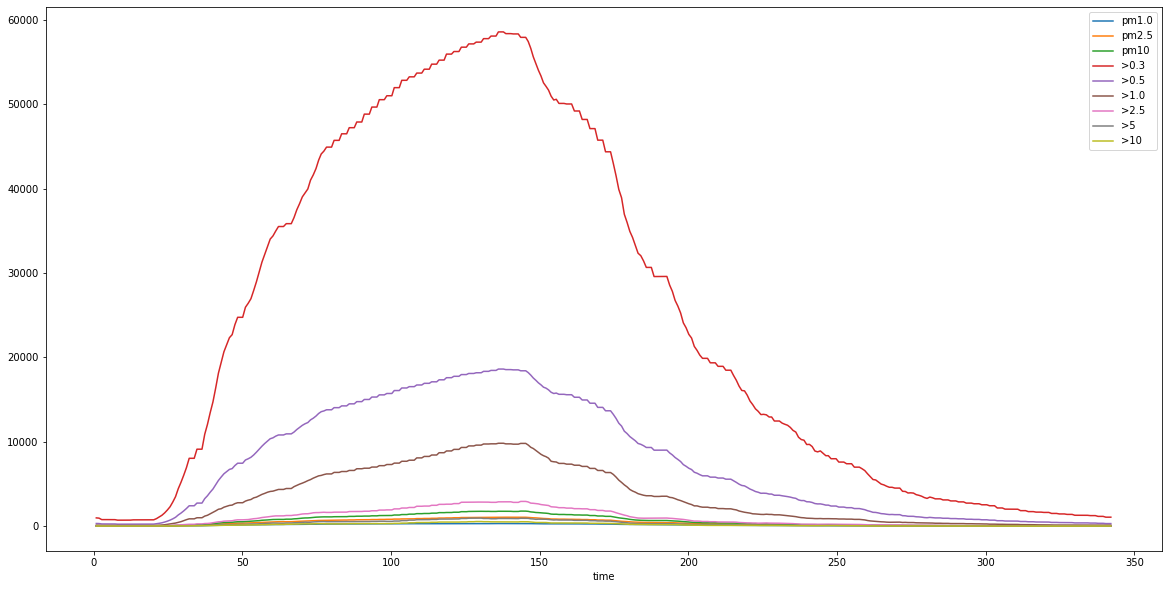

In [15]:
#df = pd.read_csv('data/20220623_4_ArcticP14_4_ikea_100_pwr.csv')
#df = pd.read_csv('data/20220623_2_iPPC3000_2_ikea_100_pwr.csv')
#df = pd.read_csv('data/20220623_2_iPPC3000_2_ikea_66_pwr.csv')
#df = pd.read_csv('data/20220623_Levoit400s_4_spd.csv')
#df = pd.read_csv('data/20220623_ACH_vd.csv')
#df = pd.read_csv('data/20220624_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('data/20220624_4_A12x25_3_Starkvind_100_pwr_0_days.csv')
#df = pd.read_csv('data/20220624_4_A12x25_3_Starkvind_100_pwr_44_days.csv')
#df = pd.read_csv('data/20220626_2_NF-P12_redux1700PWM_2_Starkvind_100_pwr.csv')
#df = pd.read_csv('data/20220701_LaskoB20201_4_Filtrete1900_1_spd.csv')
#df = pd.read_csv('data_smoke/20220707c_Levoit400s_4_spd.csv')
#df = pd.read_csv('data/20220705a_Levoit400s_4_spd.csv')
#df = pd.read_csv('data_jet/20220704_4_ArcticP14_4_Starkvind_100_pwr.csv')
#df = pd.read_csv('data_mesh/20220712_4_A12x25_3_Starkvind_100_pwr_0_days.b.csv')
#df = pd.read_csv('data_mesh/20220712_2_iPPC3000_2_Starkvind_100_pwr.b.csv')
#df = pd.read_csv('data_mesh/20220712_ACH_vd.csv')
#df = pd.read_csv('data_mesh/20220705a_4_ArcticP14_4_Starkvind_100_pwr.csv')
#df = pd.read_csv('data_mesh/20220705a_Levoit400s_4_spd.csv')
df = pd.read_csv('data_mesh/20220718_4_A12x25_3_Starkvind_100_pwr_0_days.b.csv')

# plot the original data
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

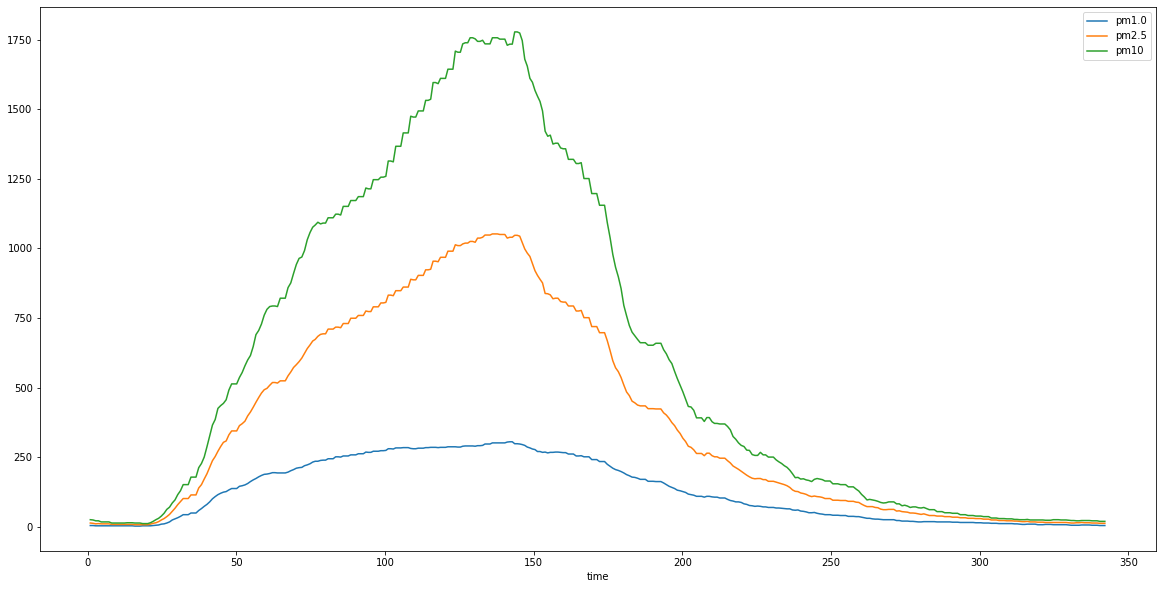

In [16]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()

# plot only pm1.0, pm2.5, and pm10
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

In [17]:
# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
# version of the functions where ACH is unknown and has to be solved for
class DecayFuncsACHUnk:
    def __init__(self, C_bgd, C_pt0):
        ## logarithmic function
        def func(t, ACH):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        def linear_func(t, ACH):
            return np.log(C_pt0) - ACH * t / 3600

        self.func = func
        self.linear_func = linear_func

# version of the functions where ACH is known and passed as a param
class DecayFuncsACH:
    def __init__(self, C_bgd, C_pt0, ACH):
        ## logarithmic function
        def func(t):
            # divide by 3600 to convert seconds to hours
            return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

        def linear_func(t):
            return np.log(C_pt0) - ACH * t / 3600

        self.func = func
        self.linear_func = linear_func


In [18]:
# begin window search at pm2.5 max
pm25_max_idx = df.idxmax()['pm2.5']
if pm25_max_idx != 0:
    df = df.tail(-pm25_max_idx)
df.index = df.index - df.index[0]
df.time = df.time - df.time[0]

end_start_search = df[df['>0.3'] < 65535].index[0]
if end_start_search == 0:
    end_start_search = 1

def test_fit(df):
    # cut all values after pm2.5 gets to about 25, they have an outsized impact on fit after converting to log
    lt25_iloc = df[df['pm2.5'] < 25].index[0]
    df = df[:lt25_iloc]

    C_bgd = 0
    C_pt0 = df['pm2.5'][df.index[0]]
    f = DecayFuncsACHUnk(C_bgd, C_pt0)

    popt, pcov = curve_fit(f.linear_func, df.time, np.log(df['pm2.5']))
    ACH = popt[0]
    stddev = np.sqrt(np.diag(pcov)[0])
    return (C_pt0, ACH, stddev)

fits = []
for i in range(end_start_search):
    df_pm25 = df[['time','pm2.5']].copy()

    if i != 0:
        df_pm25 = df_pm25.tail(-i)
        # adjust times according to new t0 after tail was run
        df_pm25.time = df_pm25.time - df_pm25.time.iloc[0]
        df_pm25.index = df_pm25.index - df_pm25.index[0]
    
    C_pt0, ACH, stddev = test_fit(df_pm25)
    fits.append((i, C_pt0, ACH, stddev))
df_fits = pd.DataFrame(fits, columns=['i', 'C_pt0', 'ACH', 'stddev'])
j = df_fits.idxmin()['stddev']
print('time: {}'.format(df.time[df_fits.i[j]]))
print('C_pt0: {}'.format(df_fits.C_pt0[j]))
print('ACH: {}'.format(df_fits.ACH[j]))
print('stddev: {}'.format(df_fits.stddev[j]))

C_pt0 = df_fits.C_pt0[j]
ACH = df_fits.ACH[j]
stddev = df_fits.stddev[j]
f = DecayFuncsACH(0, C_pt0, ACH)


time: 0.0
C_pt0: 1052
ACH: 75.26129393207577
stddev: 0.4526063656755783


<AxesSubplot:xlabel='time'>

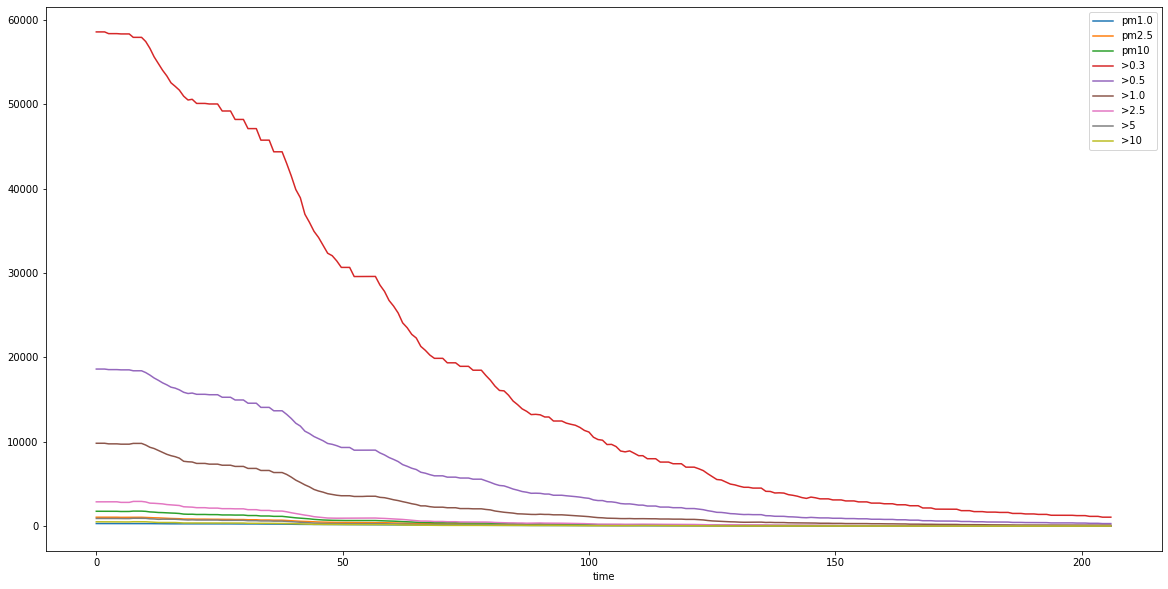

In [19]:
# cut the data down to the new start time
drop_start_idx = j
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx)
# adjust times according to new t0 after tail was run
df.time = df.time - df.time.iloc[0]
df.index = df.index - df.index[0]

df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

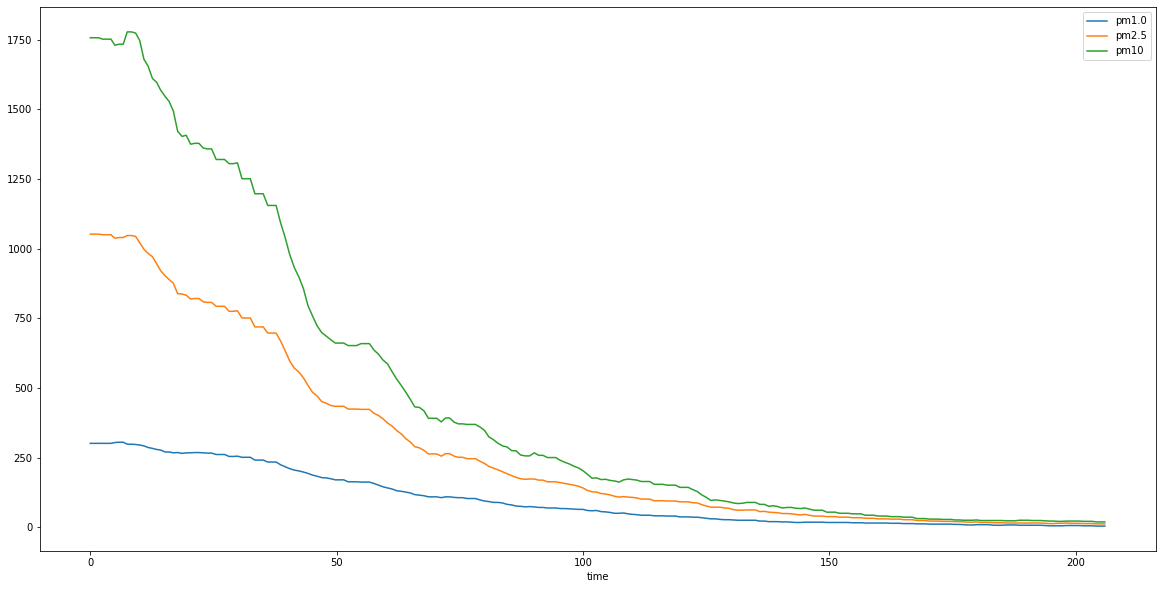

In [20]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()

# plot only pm1.0, pm2.5, and pm10
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

For this next part don't forget to change ACH_vd (ACH due to ventilation and deposition) and V_r (Volume of room/chamber) to match your values.

stddev: 0.4526063656755783


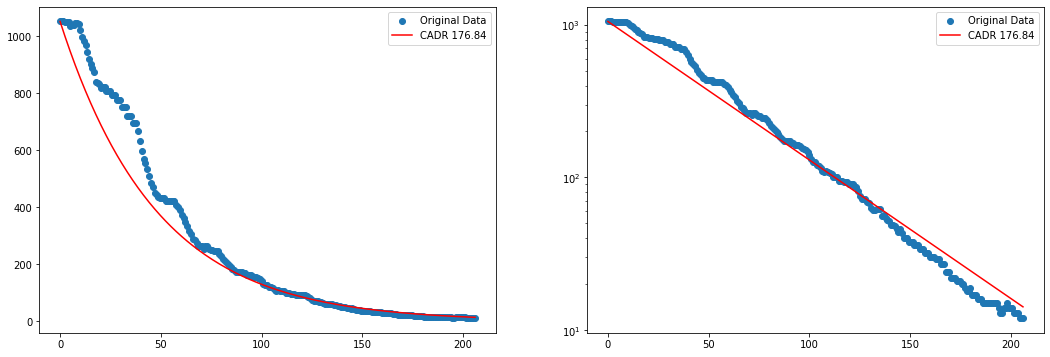

In [21]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd_jet = 3.658926048639792
ACH_vd_mesh = 2.912471532954517
ACH_vd_smoke = 2.077014966951169
ACH_vd = ACH_vd_mesh
ACH_f = ACH - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

print('stddev: {}'.format(stddev))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

plt.subplot(121)
plt.scatter(df.time, df['pm2.5'], label="Original Data")
plt.plot(df.time, f.func(df.time), 'r-', label="CADR {:0.2f}".format(CADR))
plt.legend()

plt.subplot(122)
plt.scatter(df.time, df['pm2.5'], label="Original Data")
plt.plot(df.time, f.func(df.time), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()